In [90]:
import pandas as pd

# import packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, KFold 
from sklearn.model_selection import cross_val_score
from sklearn import linear_model, metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler 
df = pd.read_csv('house_data_census.csv')

In [91]:
df = df[df.tracts != '0']
df = df.replace('?', np.nan)
df.sqft_basement = df.sqft_basement.replace('?', np.nan)
df.sqft_basement = df.sqft_basement.astype(float)
df = df.replace(np.nan, 0)
df['compared_to_neighbors'] = df['sqft_living']/df['sqft_living15']


In [92]:
df['tract_num'] = df.tracts.str[5:]
df.tract_num  = df.tract_num.astype(int)

In [93]:
X = df.copy()
y = df.price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)


In [94]:
numeric = ['sqft_living', 'sqft_lot', 'sqft_living15', 'sqft_lot15', 'grade', 'condition', 'sqft_lot15', 'sqft_above', 'bathrooms', 'bedrooms', 'yr_built', 'compared_to_neighbors']

cats = ['tract_num']

In [95]:
ohe = OneHotEncoder(sparse=False)
ohe.fit(X_train[cats])

X_train_encoded = ohe.transform(X_train[cats])
X_test_encoded = ohe.transform(X_test[cats])

X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=ohe.get_feature_names())
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=ohe.get_feature_names())
# X_train_ohe = pd.DataFrame(ohe.transform(X_train[['tract_num']]), columns = ohe.get_feature_names())
# X_train_ohe.columns = X_train_ohe.columns.str.replace('x0', 'census_tract')
# X_train = pd.concat([X_train[numeric].reset_index(), X_train_ohe], axis=1)
# #X_train = X_train.drop('index', axis=1)

In [96]:
scaler = MinMaxScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[numeric]), columns=numeric)
X_test_scaled = pd.DataFrame(scaler.transform(X_test[numeric]), columns=numeric)

In [97]:
X_train_concat = pd.concat([X_train_scaled, X_train_encoded_df], axis=1)
X_test_concat = pd.concat([X_test_scaled, X_test_encoded_df], axis=1)

In [98]:
#X_train['target'] = y_train
#X_train = X_train[np.abs(stats.zscore(X_train['target'])) < 3]
#y_train = X_train['target']
#X_train = X_train.drop('target', axis = 1)

In [99]:
y_train = np.log(y_train)
y_test = np.log(y_test)

In [100]:
print('Training features length: ', len(X_train_concat))
print('Testing features length: ', len(X_test_concat))
print('Training target length: ', len(y_train))
print('Testing target length: ', len(y_test))

Training features length:  16178
Testing features length:  5393
Training target length:  16178
Testing target length:  5393


In [101]:
lr = LinearRegression()

In [102]:
lr.fit(X_train_concat, y_train)

LinearRegression()

In [103]:
train_preds = lr.predict(X_train_concat)
test_preds = lr.predict(X_test_concat)

In [104]:
lr.score(X_test_concat, y_test)

0.8781671242768214

In [105]:
train_error = mean_squared_error(np.exp(y_train), np.exp(train_preds), squared = False)
test_error = mean_squared_error(np.exp(y_test), np.exp(test_preds), squared = False)

In [106]:
train_error, test_error

(137690.5396989328, 137253.68428526042)

In [140]:
quantiles = pd.DataFrame(pd.qcut(np.exp(y_train), q=10))

In [141]:
quantiles['price'].value_counts()

(399940.0, 450000.0]     1661
(245910.0, 299000.0]     1653
(594950.0, 700000.0]     1619
(884930.0, 7700000.0]    1618
(77999.999, 245910.0]    1618
(519500.0, 594950.0]     1617
(345635.0, 399940.0]     1617
(700000.0, 884930.0]     1616
(299000.0, 345635.0]     1583
(450000.0, 519500.0]     1576
Name: price, dtype: int64

In [142]:
e = np.exp(lr.predict(X_train_concat)) - np.exp(y_train)

In [143]:
e

15981      -484.009724
9576      71107.160101
1212      97024.323703
18840    -66427.220461
20748    -38713.180502
             ...      
11296    -82968.380415
11977     50561.750290
5397     103160.277441
860     -100637.730932
15814   -643223.025776
Name: price, Length: 16178, dtype: float64

In [144]:
quantiles.shape

(16178, 1)

In [145]:
quantiles['error'] = e

In [146]:
error_df = quantiles.groupby('price').mean()['error']
error_df = pd.DataFrame(error_df).reset_index()

<AxesSubplot:xlabel='price'>

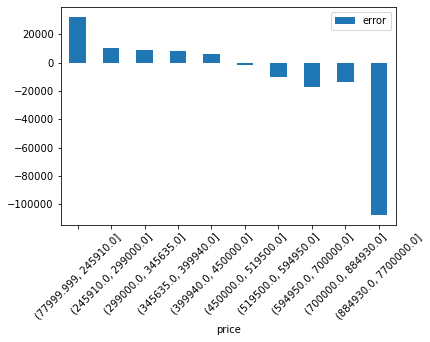

In [147]:
error_df.plot.bar(x='price', y='error', rot=45)

(array([7.500e+01, 6.320e+02, 4.116e+03, 7.229e+03, 6.218e+03, 2.371e+03,
        7.090e+02, 1.810e+02, 3.300e+01, 7.000e+00]),
 array([11.26446411, 11.72369078, 12.18291746, 12.64214414, 13.10137082,
        13.5605975 , 14.01982417, 14.47905085, 14.93827753, 15.39750421,
        15.85673089]),
 <BarContainer object of 10 artists>)

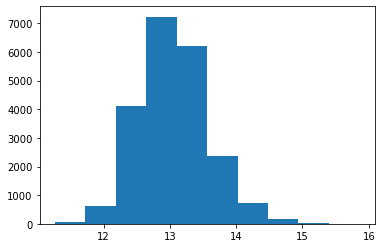

In [134]:
plt.hist(np.log(y))

In [24]:
X = df.drop(['field_1', 'id', 'floors', 'zipcode', 'waterfront', 'view', 'price', 'date', 'tracts'], axis = 1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

In [25]:
X_train['target'] = y_train
X_train_no = X_train[(np.abs(stats.zscore(X_train[['sqft_living', 'sqft_lot', 'sqft_living15', 'sqft_lot15', 'sqft_above', 'bathrooms', 'bedrooms', 'target']])) < 3).all(axis=1)].drop_duplicates()
y_train_no = X_train_no['target']
X_train_no = X_train_no.drop('target', axis = 1)


<ipython-input-25-5e35db3e1a1c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['target'] = y_train


In [26]:
df['tract_num'] = df.tracts.str[5:]

In [27]:
df.tract_num  = df.tract_num.astype(int)

In [28]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train_no)
X_test_scaled = scaler.transform(X_test)

In [29]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_no.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [32]:
df.isna().sum()

field_1                  0
id                       0
date                     0
price                    0
bedrooms                 0
bathrooms                0
sqft_living              0
sqft_lot                 0
floors                   0
waterfront               0
view                     0
condition                0
grade                    0
sqft_above               0
sqft_basement            0
yr_built                 0
yr_renovated             0
zipcode                  0
lat                      0
long                     0
sqft_living15            0
sqft_lot15               0
tracts                   0
ESL_Score                0
Income_Sco               0
RE_Score                 0
TotalScore               0
WeightedTo               0
PercentESL               0
MedianHous               0
PercentPOC               0
compared_to_neighbors    0
tract_num                0
dtype: int64